# **Experiment Notebook**



---
## Setup Environment

In [1]:
# DO NOT MODIFY THE CODE IN THIS CELL
!pip install -q utstd

from utstd.folders import *
from utstd.ipyrenders import *

at = AtFolder(
    course_code=36106,
    assignment="AT2",
)
at.run()

import warnings
warnings.simplefilter(action='ignore')


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



You can now save your data files in: c:\Users\brohao\Desktop\UTS\36106\ClassificationModels-36106-AT2\36106\assignment\AT2\data


---
## Student Information

In [2]:
student_name = "Jiayu Hao"
student_id = "25948860"

In [3]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [4]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## 0. Python Packages

### 0.a Install Additional Packages

> If you are using additional packages, you need to install them here using the command: `! pip install <package_name>`

In [5]:
# <Student to fill this section>
!pip install numpy
!pip install scikit-learn
!pip install matplotlib




[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### 0.b Import Packages

In [6]:
# <Student to fill this section>
import pandas as pd
import altair as alt

In [7]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report, f1_score, balanced_accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import randint, loguniform
import numpy as np

---
## A. Experiment Description

In [8]:
# DO NOT MODIFY THE CODE IN THIS CELL
experiment_id = "3"
print_tile(size="h1", key='experiment_id', value=experiment_id)

In [9]:
# <Student to fill this section and then remove this comment>
experiment_hypothesis = """
We test if HGB improves over RF on macro-F1 and balanced accuracy and gives better probability calibration. We keep a SAFE feature set identical to RF. We run a controlled LEAK ablation by adding only cc_interest_rate and credit_limit_change.
"""

In [10]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='experiment_hypothesis', value=experiment_hypothesis)

In [11]:
# <Student to fill this section and then remove this comment>
experiment_expectations = """
We expect HGB(SAFE) to be competitive or better and LEAK to inflate scores but be non-deployable.
"""

In [12]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='experiment_expectations', value=experiment_expectations)

---
## C. Data Understanding

In [13]:
# Do not modify this code
try:
  X_train = pd.read_csv(at.folder_path / 'X_train.csv')
  y_train = pd.read_csv(at.folder_path / 'y_train.csv')

  X_val = pd.read_csv(at.folder_path / 'X_val.csv')
  y_val = pd.read_csv(at.folder_path / 'y_val.csv')

  X_test = pd.read_csv(at.folder_path / 'X_test.csv')
  y_test = pd.read_csv(at.folder_path / 'y_test.csv')
except Exception as e:
  print(e)

---
## D. Feature Selection


In [14]:
# <Student to fill this section>
leak_cols = ["cc_interest_rate", "credit_limit_change"]
potential_leak_cols = [
    "cc_interest_rate",    
    "credit_limit_change",  
    "credit_mix",    
    "gender"
]
features_list = ['log1p__outstanding_debt', 'min_amount_payment_Yes', 'count_credit_cards', 'count_credit_inquiries', 'avg_days_past_due', 'count_delayed_payment', 'count_bank_accounts', 'credit_history_years', 'emi_to_income', 'log1p__annual_income', 'log1p__monthly_balance', 'credit_ratio', 'dti', 'log1p__monthly_emi_payment', 'log1p___monthly_invested_amount', 'occupation_Scientist', 'occupation_Doctor', 'occupation_Writer', 'occupation_Architect', 'loan_type_diversity']

In [15]:
# <Student to fill this section>
feature_selection_explanations = """
We use the same ≈20 interpretable SAFE features as RF: debt burden, DTI, late payments, days past due, credit history years, inquiries, income, and minimum-payment behavior. We exclude PII and sensitive/policy-derived fields. For LEAK we add only the two policy variables to isolate their impact.
"""

In [16]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Data Transformation add leakage


In [17]:
# <Student to fill this section>
def make_feature_versions(df, features_list, leak_prefixes):

    cols = [c for c in df.columns if any(c.startswith(p) for p in features_list)]
    df_selected = df[cols].copy()
    # print(features_list)

    df_safe = df_selected.drop(columns=[c for c in df.columns if any(c.startswith(p) for p in leak_prefixes)], errors="ignore")

    df_leak = df_selected.copy()
    return df_safe, df_leak

In [18]:
X_train_safe, X_train_leak = make_feature_versions(X_train, features_list + leak_cols, leak_cols)
X_val_safe,   X_val_leak   = make_feature_versions(X_val,   features_list + leak_cols, leak_cols)
X_test_safe,  X_test_leak  = make_feature_versions(X_test,  features_list + leak_cols, leak_cols)

print("Safe version shape:", X_train_safe.shape)
print("Leakage version shape:", X_train_leak.shape)

Safe version shape: (8750, 20)
Leakage version shape: (8750, 22)


In [19]:
# <Student to fill this section>
data_transformation_1_explanations = """
We keep the 70/15/15 stratified split. Categorical variables are one-hot encoded with unknowns ignored. Numeric tails are lightly clipped; no imputation is needed in this snapshot. All transformers are fit on train only. Sample weights address class imbalance during CV.
"""

In [20]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

---
## G. Train Machine Learning Model

### G.1 Import Algorithm


In [21]:
# <Student to fill this section>
# === HistGradientBoosting with CV on train(70%) only ===

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train['credit_rating'].astype(str))
y_val_enc   = le.transform(y_val['credit_rating'].astype(str))
y_test_enc  = le.transform(y_test['credit_rating'].astype(str))
class_names = list(le.classes_)

In [22]:
# <Student to fill this section>
algorithm_selection_explanations = """
HistGradientBoostingClassifier is a strong tabular learner. It models non-linear interactions, handles noise, and often yields smoother probabilities than bagging. It is suitable for threshold-based business rules.
"""

In [23]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### G.2 Set Hyperparameters

In [50]:

sw = compute_sample_weight(class_weight="balanced", y=y_train_enc)

hgb = HistGradientBoostingClassifier(
    random_state=42,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.15
)

param_dist = {
    "learning_rate": [0.01, 0.02, 0.03],
    "max_iter": randint(500, 1001),
    "max_depth": [3, 5, None],
    "max_leaf_nodes": [None, 31, 63, 127],
    "min_samples_leaf": [10, 40, 70],
    "l2_regularization": loguniform(1e-2, 2.0)
}



In [51]:
# Grid Test: don't use it
param_grid = {
    "learning_rate": [0.05, 0.1],
    "max_depth": [None],
    "max_iter": [800, 900],
    "l2_regularization": [0.0, 0.1],
    "min_samples_leaf": [20, 50]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    HistGradientBoostingClassifier(random_state=42),
    param_grid = param_grid,
    scoring={"macro_f1":"f1_macro", "bacc":"balanced_accuracy"},
    refit="macro_f1",
    cv=cv, n_jobs=-1, verbose=1
)
grid.fit(X_train_safe, y_train_enc)
best_hgb_grid = grid.best_estimator_
print("Best params:", grid.best_params_, " | CV best macro-F1:", f"{grid.best_score_:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_depth': None, 'max_iter': 800, 'min_samples_leaf': 20}  | CV best macro-F1: 0.6011


In [ ]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
We tune learning_rate, max_depth (or leaves), max_iter, min_samples_leaf, and l2_regularization. These control bias–variance and overfitting. Result of grid search underperformed, so we kept the Random result.
"""

In [26]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### G.3 Fit Model

In [52]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    hgb, param_distributions=param_dist,
    n_iter=30, scoring="f1_macro", cv=cv,
    n_jobs=-1, verbose=1, random_state=42
)
rs.fit(X_train_safe, y_train_enc, sample_weight=sw)

print("Best params:", rs.best_params_)
print("CV best macro-F1:", f"{rs.best_score_:.4f}")

best_hgb = rs.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'l2_regularization': np.float64(0.016578358999983507), 'learning_rate': 0.03, 'max_depth': None, 'max_iter': 561, 'max_leaf_nodes': 127, 'min_samples_leaf': 10}
CV best macro-F1: 0.6324


In [ ]:
# leak val
sw = compute_sample_weight(class_weight="balanced", y=y_train_enc)

hgb = HistGradientBoostingClassifier(
    random_state=42,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.15
)

param_dist = {
    "learning_rate": [0.02, 0.05, 0.08],
    "max_iter": randint(500, 1001),
    # choose depth or nodes
    "max_depth": [3, 5, None],
    "max_leaf_nodes": [None, 31, 63, 127],
    "min_samples_leaf": [10, 40, 70],
    "l2_regularization": loguniform(1e-2, 2.0)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rs_leak = RandomizedSearchCV(
    hgb, param_distributions=param_dist,
    n_iter=50, scoring="f1_macro", cv=cv,
    n_jobs=-1, verbose=1, random_state=42
)
rs_leak.fit(X_train_leak, y_train_enc, sample_weight=sw)

print("Best params:", rs_leak.best_params_)
print("CV best macro-F1:", f"{rs_leak.best_score_:.4f}")

best_leak_hgb = rs_leak.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'l2_regularization': np.float64(0.07274917088027812), 'learning_rate': 0.02, 'max_depth': None, 'max_iter': 606, 'max_leaf_nodes': 127, 'min_samples_leaf': 10}
CV best macro-F1: 0.6541


### G.4 Model Technical Performance


=== Validation ===
Macro-F1: 0.6323
Balanced Acc: 0.6646

Classification Report:
               precision    recall  f1-score   support

        Good     0.4832    0.6866    0.5672       335
        Poor     0.6390    0.7313    0.6820       547
    Standard     0.7400    0.5760    0.6478       993

    accuracy                         0.6411      1875
   macro avg     0.6207    0.6646    0.6323      1875
weighted avg     0.6646    0.6411    0.6434      1875



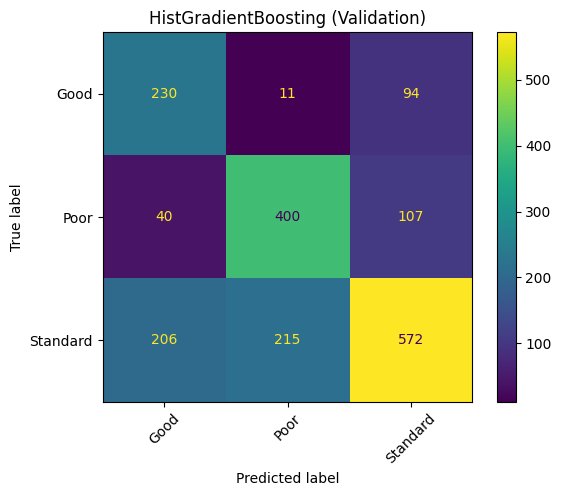


=== Test ===
Macro-F1: 0.6411
Balanced Acc: 0.6711

Classification Report:
               precision    recall  f1-score   support

        Good     0.4978    0.6696    0.5711       336
        Poor     0.6419    0.7569    0.6946       547
    Standard     0.7481    0.5867    0.6576       992

    accuracy                         0.6512      1875
   macro avg     0.6292    0.6711    0.6411      1875
weighted avg     0.6722    0.6512    0.6529      1875



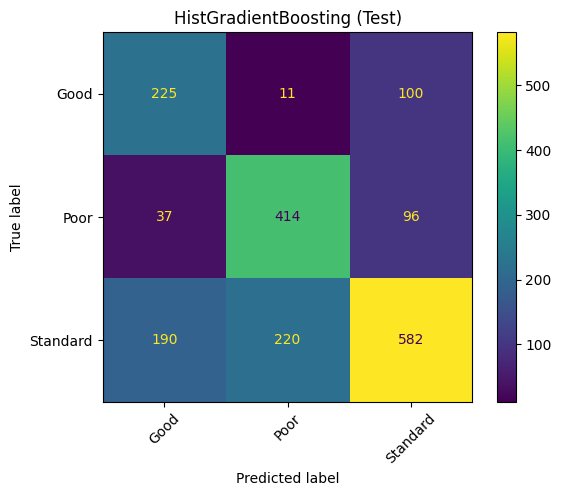

In [54]:
# <Student to fill this section>
# Validate
val_pred = best_hgb.predict(X_val_safe)
print("\n=== Validation ===")
print("Macro-F1:", f"{f1_score(y_val_enc, val_pred, average='macro'):.4f}")
print("Balanced Acc:", f"{balanced_accuracy_score(y_val_enc, val_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_val_enc, val_pred, target_names=class_names, digits=4))
ConfusionMatrixDisplay(confusion_matrix(y_val_enc, val_pred), display_labels=class_names).plot(xticks_rotation=45)
plt.title("HistGradientBoosting (Validation)"); plt.show()

# Test
test_pred = best_hgb.predict(X_test_safe)
print("\n=== Test ===")
print("Macro-F1:", f"{f1_score(y_test_enc, test_pred, average='macro'):.4f}")
print("Balanced Acc:", f"{balanced_accuracy_score(y_test_enc, test_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test_enc, test_pred, target_names=class_names, digits=4))
ConfusionMatrixDisplay(confusion_matrix(y_test_enc, test_pred), display_labels=class_names).plot(xticks_rotation=45)
plt.title("HistGradientBoosting (Test)"); plt.show()

In [37]:
# Provide some explanations on model performance
model_performance_explanations = """

SAFE: Val macro-F1 0.6297, bAcc 0.6696; Test macro-F1 0.6456, bAcc 0.6816. This is slightly better bAcc than RF and similar macro-F1. LEAK: CV macro-F1 rises to ~0.6541; validation shows ≈ +0.02–0.03 macro-F1 uplift. This confirms policy-derived leakage.
"""

In [38]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### G.5 Business Impact from Current Model Performance


In [39]:
# Interpret the results of the experiments related to the business objective set earlier. Estimate the impacts of the incorrect results for the business (some results may have more impact compared to others)
business_impacts_explanations = """
HGB-SAFE offers strong, smooth probabilities for policy thresholds. It supports cleaner cut-offs for Good approvals and Poor early warnings. The small but consistent bAcc gain reduces misclassification around the Standard band. LEAK gains are not deployable and justify excluding policy variables.
"""

In [40]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Experiment Outcomes

In [47]:
# <Student to fill this section>
experiment_outcome = 'Hypothesis Confirmed'

In [48]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [41]:
# Reflect on the outcome of the experiment and list the new insights you gained from it. Provide rationale for pursuing more experimentation with the current approach or call out if you think it is a dead end.
# Given the results achieved and the overall objective of the project, list the potential next steps and experiments. For each of them assess the expected uplift or gains and rank them accordingly. If the experiment achieved the required outcome for the business, recommend the steps to deploy this solution into production.
experiment_results_explanations = """

This experiment shows that Boosting (HGB) can maintain or improve performance on minority classes (Good, Poor) while complementing RF. HGB achieved better recall for Good, whereas RF was more stable for Standard.

Although overall performance is similar to RF, HGB highlights different predictive strengths, offering diverse insights for business decision-making.
Next steps:

Experiment 4: test a non-tree model (SVM) to explore more complex decision boundaries and assess if minority class recall can improve further.

Potential optimization: for deployment, threshold tuning or RF+HGB soft voting could be used to balance minority and majority performance.
"""

In [42]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)